### Trực quan hoá đa biến để tìm ra các đặc trưng quan trọng cho quá trình training

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
arsenal_df = pd.read_csv("../../feature_engineering_data/train/manchester_united.csv")

In [3]:
arsenal_df.columns

Index(['opponent', 'venue', 'season', 'result', 'win_percent_before_team1',
       'lose_percent_before_team1', 'draw_percent_before_team1',
       'win_percent_before_team2', 'lose_percent_before_team2',
       'draw_percent_before_team2', 'total_goals_before_team1',
       'total_lost_goals_before_team1', 'total_goals_before_team2',
       'total_lost_goals_before_team2', 'ELO_before_match_team1',
       'ELO_before_match_team2', 'ELO_after_match_team1',
       'ELO_after_match_team2', 'average_score_before_match_team1',
       'average_score_before_match_team2', 'date_time',
       'head2head_win_percent', 'head2head_draw_percent',
       'head2head_lost_percent', 'is_opponent_big6'],
      dtype='object')

In [4]:
arsenal_df = arsenal_df.drop(columns=["ELO_after_match_team1", "ELO_after_match_team2"])

### 1. Xem xét sự ảnh hưởng của venue đến biến mục tiêu result

In [5]:
result_count = arsenal_df.groupby(['venue', 'result']).size().unstack().reindex(["W", "L", "D"], axis=1).reindex(["Home", "Away"])
venue_count = arsenal_df.groupby(['venue']).size().reindex(["Home", "Away"])

result_count

result,W,L,D
venue,,,
Home,136,31,42
Away,102,49,58


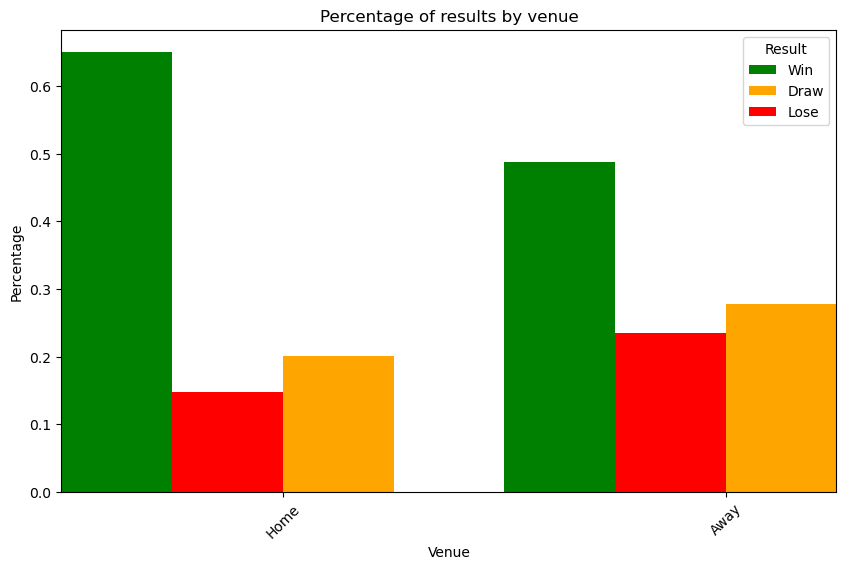

In [6]:
# Vẽ ba biểu đồ cột cho mỗi loại kết quả
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ biểu đồ cho kết quả Win
result_percentage = result_count.div(venue_count, axis=0)
result_percentage['W'].plot(kind='bar', ax=ax, color='green', position=2, width=0.25, label='Win')

# Vẽ biểu đồ cho kết quả Draw
result_percentage['D'].plot(kind='bar', ax=ax, color='orange', position=0, width=0.25, label='Draw')

# Vẽ biểu đồ cho kết quả Lose
result_percentage['L'].plot(kind='bar', ax=ax, color='red', position=1, width=0.25, label='Lose')

plt.title("Percentage of results by venue")
plt.xlabel("Venue")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title='Result')

plt.show()

Nhận xét:
- Đá trên sân nhà luôn có tỉ lệ thắng, hoà cao hơn so với tỉ lệ thua. Tỉ lệ thắng là cao rõ rệt
- Còn khi đá trên sân khách thì tỉ lệ thắng có cao hơn so với tỉ lệ thua nhưng không rõ rệt như đá trên sân nhà

Nhận xét:
- Đại đa số các trận đấu đều có %W, %D cao hơn %L, điều này cho thấy rằng trọng tài không ảnh hưởng <br/>
nhiều đến kết quả trận đấu. Do đó sẽ không sử dụng biến referee trong quá trình training

### 2. Xem xét sự ảnh hưởng của season đến kết quả

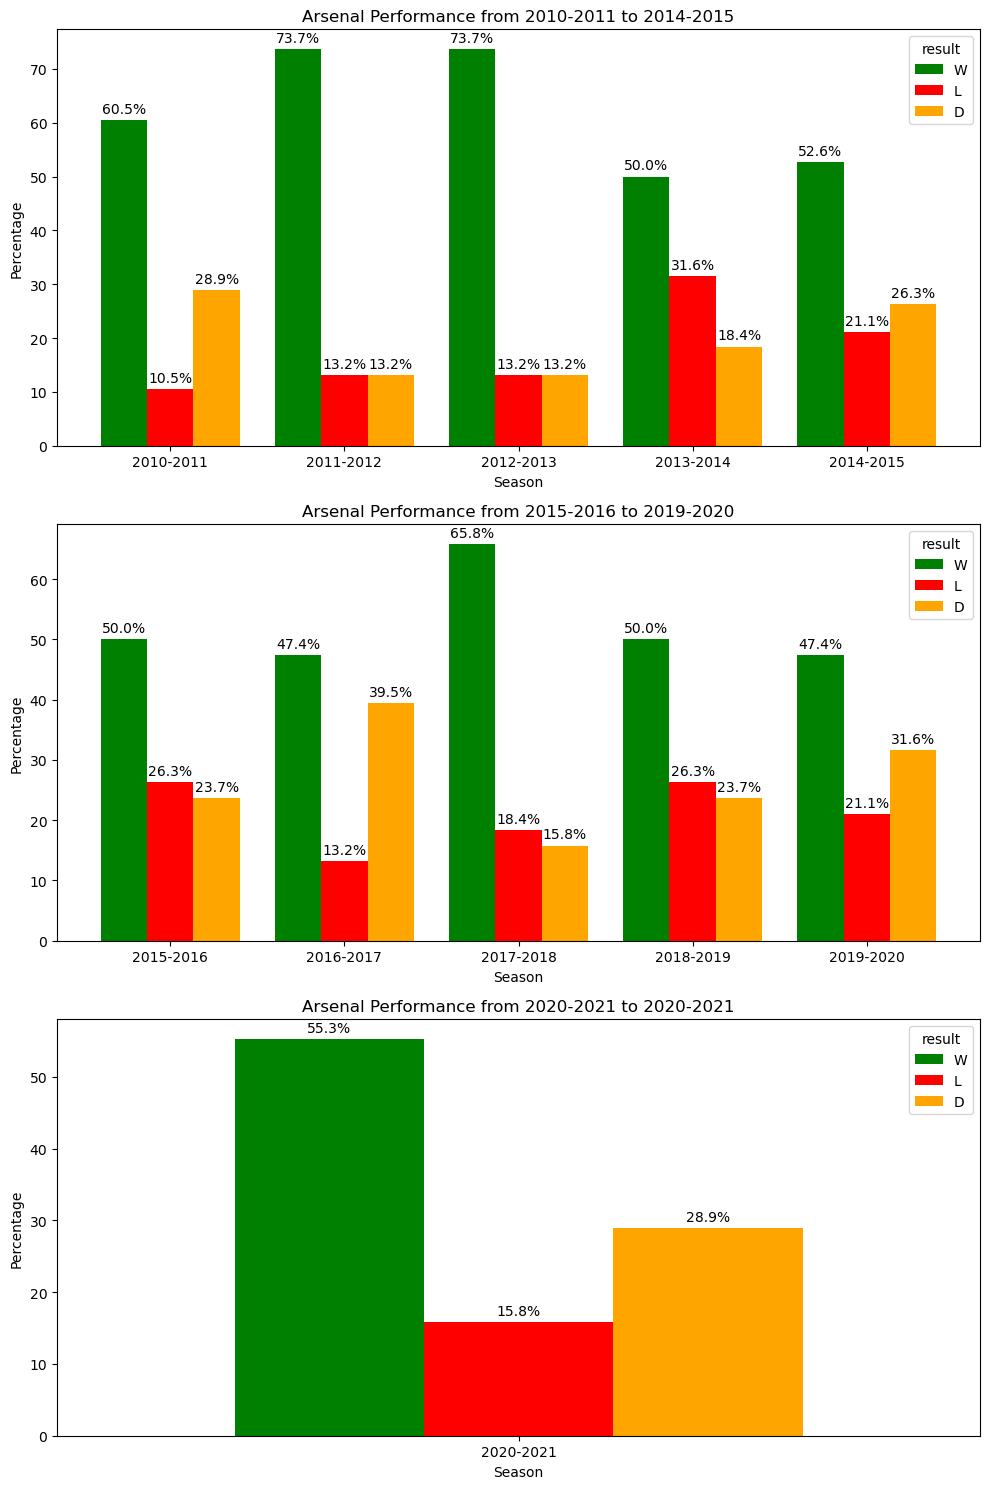

In [7]:
season_values = arsenal_df["season"].unique()
season_groups = [season_values[i:i + 5] for i in range(0, len(season_values), 5)]

# Tạo figure với số lượng subplots phù hợp với số nhóm
num_groups = len(season_groups)
fig, axs = plt.subplots(num_groups, 1, figsize=(10, 5 * num_groups))  # Adjust the size as needed

# Lặp qua mỗi nhóm và vẽ đồ thị
for idx, seasons in enumerate(season_groups):
    # Lọc dữ liệu cho các mùa giải đã chỉ định
    filtered_df = arsenal_df[arsenal_df['season'].isin(seasons)]

    # Tính phần trăm chiến thắng, hòa, thua cho mỗi mùa giải
    result_counts = filtered_df.groupby(['season', 'result']).size().unstack(fill_value=0)
    result_percentages = result_counts.div(result_counts.sum(axis=1), axis=0) * 100
    result_percentages = result_percentages[['W', 'L', 'D']]

    # Vẽ dữ liệu trong subplot tương ứng
    ax = axs[idx] if num_groups > 1 else axs  # Handle the case of a single subplot
    bars = result_percentages.plot(kind='bar', width=0.8, ax=ax, label='Result', color=['green', 'red', 'orange'])
    ax.set_title(f'Arsenal Performance from {seasons[0]} to {seasons[-1]}')
    ax.set_xlabel('Season')
    ax.set_ylabel('Percentage')

    # Chỉnh trục x-axis labels nằm ngang
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # Thêm % vào mỗi cột
    for bar_container in bars.containers:
        ax.bar_label(bar_container, fmt='%.1f%%', label_type='edge', padding=3)

# Chỉnh sửa bố cục
plt.tight_layout()

Nhận xét: kết quả thi đấu qua các mùa giải có sự thay đổi:
- Phần trăm thua, phần trăm hoà có sự biến đổi qua các mùa giải

### 3. Phong độ (win_before_team1, lose_before_team1, draw_before_team1) của đội đến kết quả

#### a. Xem xét phần trăm thắng 5 trận gần nhất của 2 đội đến kết quả

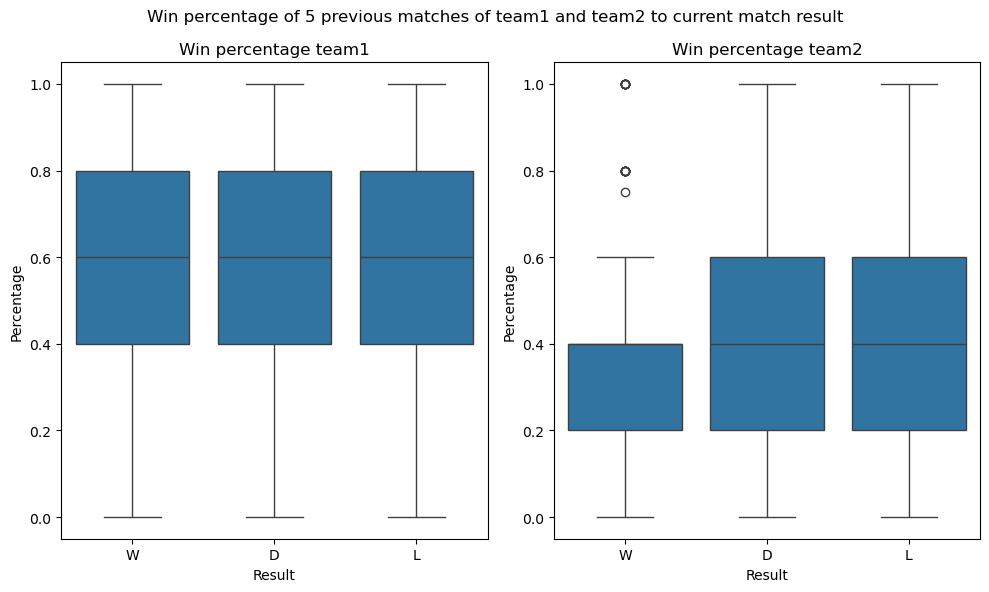

In [8]:
# Vẽ biểu đồ box plot thể hiện ảnh hưởng của tỷ lệ thắng 5 trận trước đó của 2 team đến kết quả trận đấu
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.boxplot(x='result', y='win_percent_before_team1', data=arsenal_df, ax=axes[0])
axes[0].set_title('Win percentage team1')
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.boxplot(x='result', y='win_percent_before_team2', data=arsenal_df, ax=axes[1])
axes[1].set_title('Win percentage team2')
axes[1].set_xlabel('Result')
axes[1].set_ylabel('Percentage')

plt.suptitle("Win percentage of 5 previous matches of team1 and team2 to current match result")
plt.tight_layout()

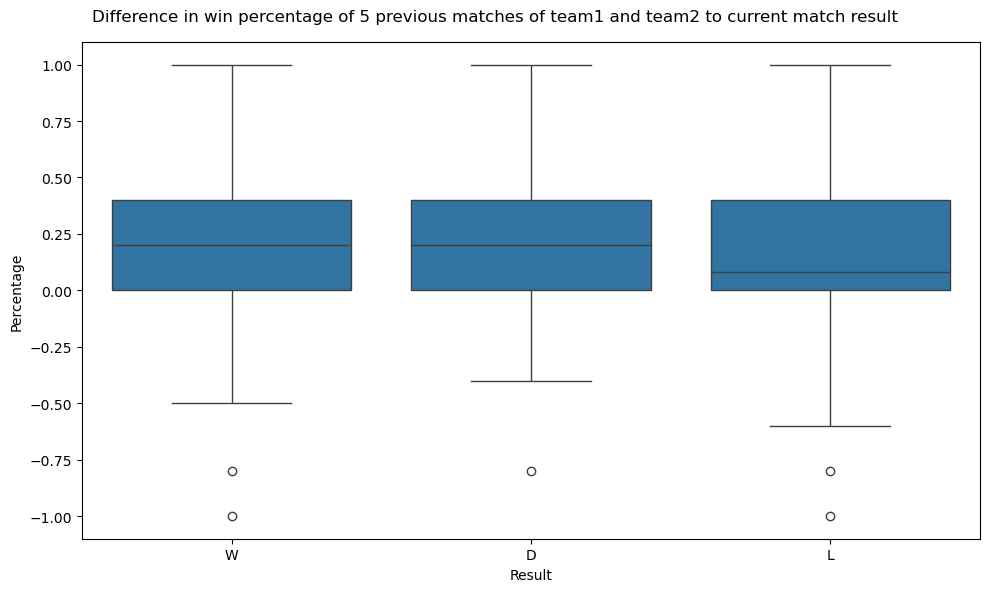

In [9]:
# Phong độ 5 trận gần nhất của đội không có sự biến động lớn, nên thử dùng hiệu số phong độ của 2 đội để xem xét
arsenal_df["win_percent_diff"] = arsenal_df['win_percent_before_team1'] - arsenal_df['win_percent_before_team2']

fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(x='result', y='win_percent_diff', data=arsenal_df, ax=ax)
ax.set_xlabel('Result')
ax.set_ylabel('Percentage')


plt.suptitle("Difference in win percentage of 5 previous matches of team1 and team2 to current match result")
plt.tight_layout()

Nhận xét:
- Có thể dùng đặc trưng: `win_percent_diff` làm biến dự đoán

### b Trực quan hoá phần trăm hoà của 2 đội đến kết quả

#### b.1 Xem xét phần trăm hoà 5 trận gần nhất của 2 đội đến kết quả

Với biến `draw_percent_before_team1`:

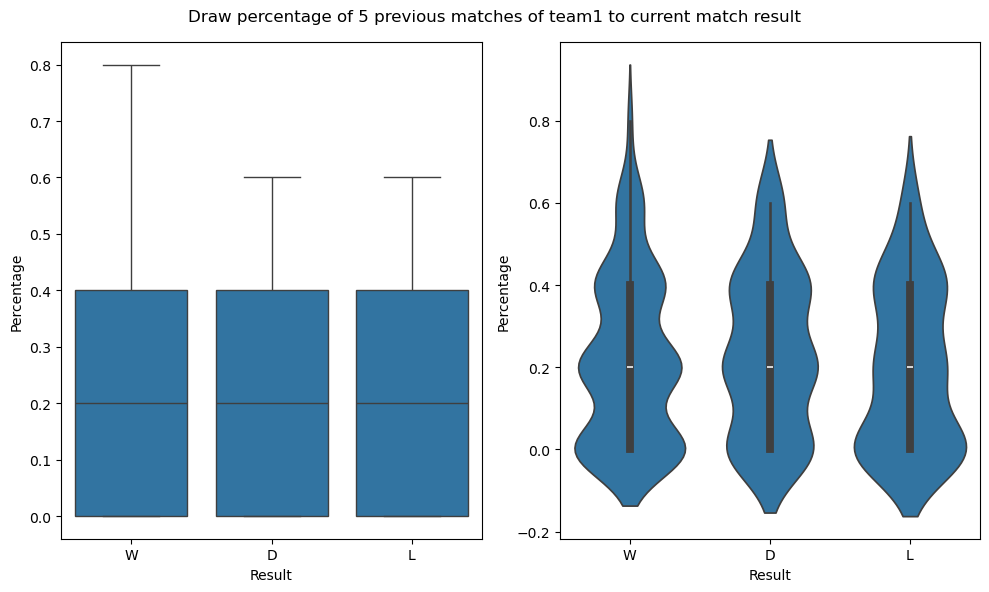

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.boxplot(x='result', y='draw_percent_before_team1', data=arsenal_df, ax=axes[0])
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.violinplot(x='result', y='draw_percent_before_team1', data=arsenal_df, ax=axes[1])
axes[1].set_xlabel('Result')
axes[1].set_ylabel('Percentage')

plt.suptitle("Draw percentage of 5 previous matches of team1 to current match result")
plt.tight_layout()

=> draw_percent_before_team1 không ảnh hưởng nhiều đến kết quả

Với biến `draw_percent_before_team2`:

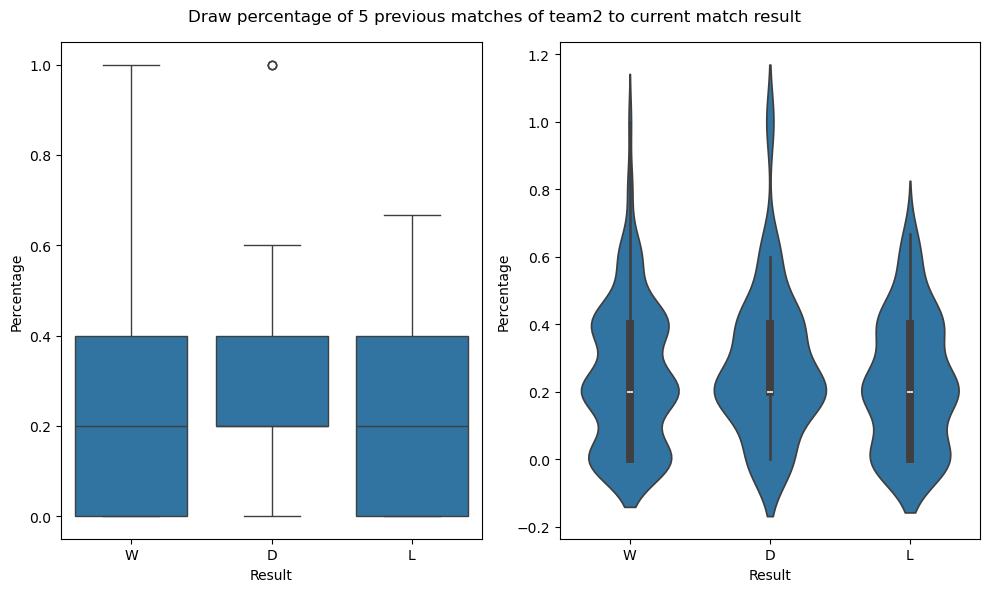

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.boxplot(x='result', y='draw_percent_before_team2', data=arsenal_df, ax=axes[0])
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.violinplot(x='result', y='draw_percent_before_team2', data=arsenal_df, ax=axes[1])
axes[1].set_xlabel('Result')
axes[1].set_ylabel('Percentage')

plt.suptitle("Draw percentage of 5 previous matches of team2 to current match result")
plt.tight_layout()

- Trung vị của draw_percent_before_team2 tương đối đồng đều giữa các nhóm L, W, và D.
- Mật độ phân bố của draw_percent_before_team2 tại đồ thị violin ở các nhóm L, W, và D tương tự nhau, không có sự khác biệt rõ rệt về hình dạng.

#### b.2 Phần trăm hoà 5 trận gần nhất của Arsenal vẫn không có sự ảnh hưởng đến kết quả

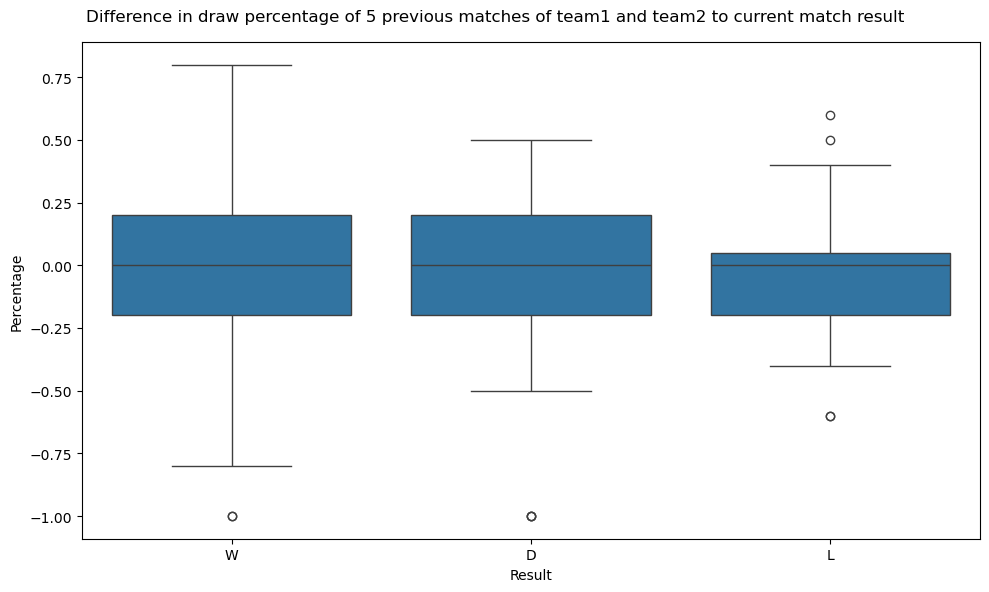

In [12]:
arsenal_df["draw_percent_diff"] = arsenal_df['draw_percent_before_team1'] - arsenal_df['draw_percent_before_team2']

fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(x='result', y='draw_percent_diff', data=arsenal_df, ax=ax)
ax.set_xlabel('Result')
ax.set_ylabel('Percentage')


plt.suptitle("Difference in draw percentage of 5 previous matches of team1 and team2 to current match result")
plt.tight_layout()

- Sẽ sử dụng biến `draw_percent_team2`, `draw_percent_diff` trong quá trình training

#### c. Xem xét phần trăm thua 5 trận gần nhất của 2 đội đến kết quả

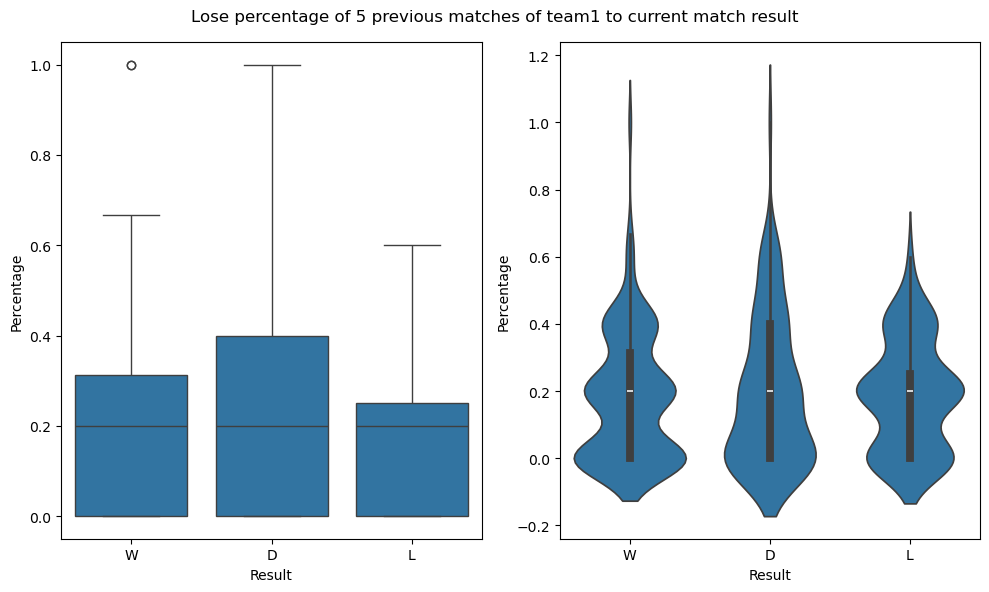

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.boxplot(x='result', y='lose_percent_before_team1', data=arsenal_df, ax=axes[0])
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.violinplot(x='result', y='lose_percent_before_team1', data=arsenal_df, ax=axes[1])
axes[1].set_xlabel('Result')
axes[1].set_ylabel('Percentage')

plt.suptitle("Lose percentage of 5 previous matches of team1 to current match result")
plt.tight_layout()

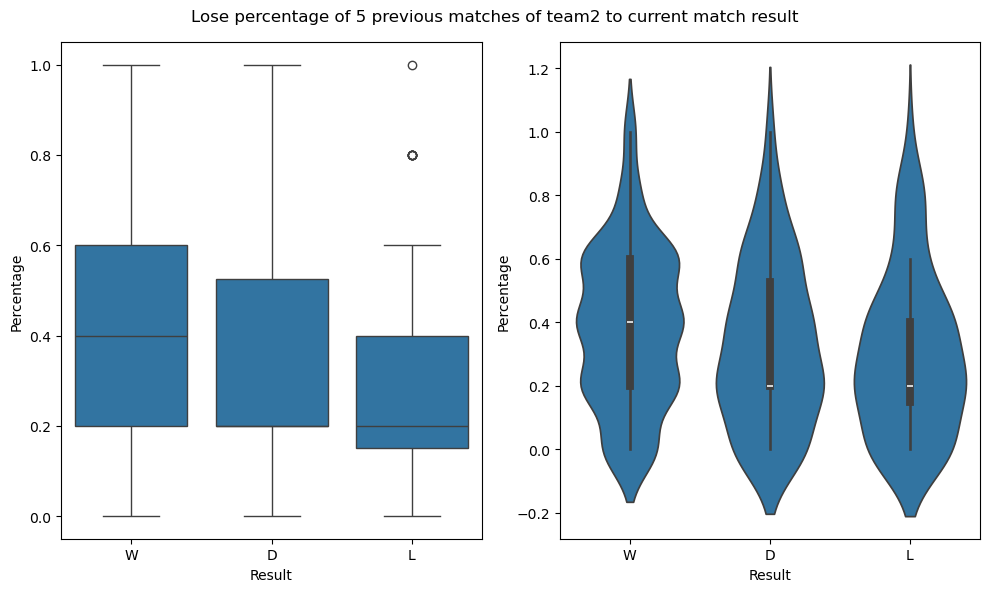

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.boxplot(x='result', y='lose_percent_before_team2', data=arsenal_df, ax=axes[0])
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.violinplot(x='result', y='lose_percent_before_team2', data=arsenal_df, ax=axes[1])
axes[1].set_xlabel('Result')
axes[1].set_ylabel('Percentage')

plt.suptitle("Lose percentage of 5 previous matches of team2 to current match result")
plt.tight_layout()

=> `lose_percent_before_team1` và `lose_percent_before_team2` `có` ảnh hưởng đến kết quả vì khi lose percentage của đội 2 càng cao thì kết quả đội 1 sẽ thắng/hoà cao hơn

#### c.2 Xem xét hiệu phần trăm thua của 2 đội đến kết quả

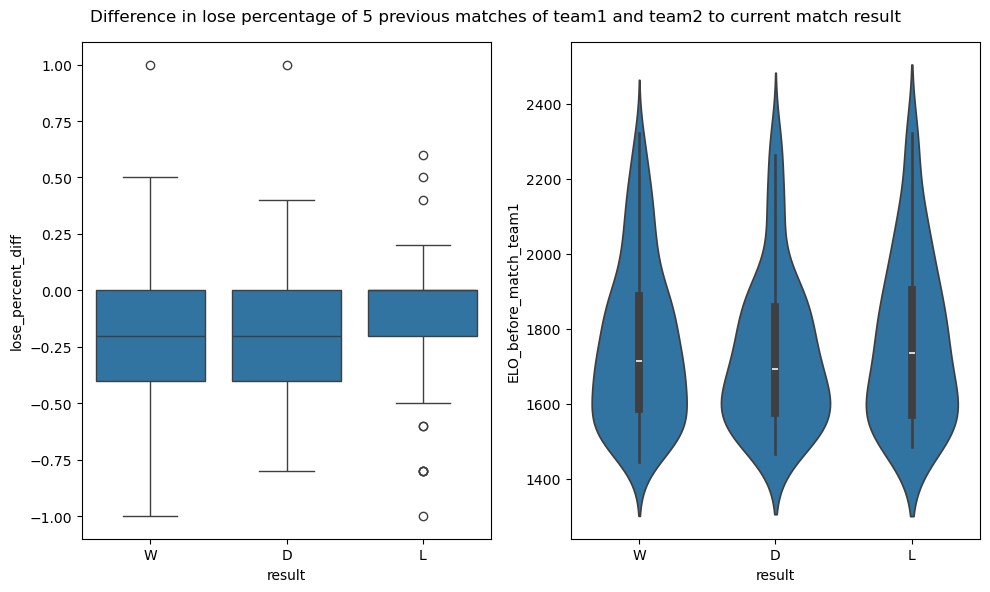

In [15]:
arsenal_df["lose_percent_diff"] = arsenal_df['lose_percent_before_team1'] - arsenal_df['lose_percent_before_team2']

fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)

sns.boxplot(x='result', y='lose_percent_diff', data=arsenal_df, ax=axes[0])
ax.set_xlabel('Result')
ax.set_ylabel('Percentage')


sns.violinplot(x='result', y='ELO_before_match_team1', data=arsenal_df, ax=axes[1])

plt.suptitle("Difference in lose percentage of 5 previous matches of team1 and team2 to current match result")
plt.tight_layout()

=> Hiệu phần trăm thua của 2 đội `không ảnh hưởng` đến kết quả

In [16]:
arsenal_df["lose_percent_diff"].groupby(arsenal_df["result"]).describe()

,count,mean,std,min,25%,50%,75%,max
result,,,,,,,,
D,100.0,-0.134333,0.301714,-0.8,-0.4,-0.2,0.0,1.0
L,80.0,-0.111042,0.291740,-1.0,-0.2,0.0,0.0,0.6
W,238.0,-0.204902,0.298063,-1.0,-0.4,-0.2,0.0,1.0


Nhận xét:
- Các biến dùng cho việc dự đoán: `lose_percent_before_team2`

Vậy sau quá trình trực quan hoá đa biến cho biến phong độ thì sẽ dùng `win_before_team2`, `lose_before_team2` để dự đoán kết quả

### 3. Xem sét sự ảnh hưởng của opponent đến kết quả

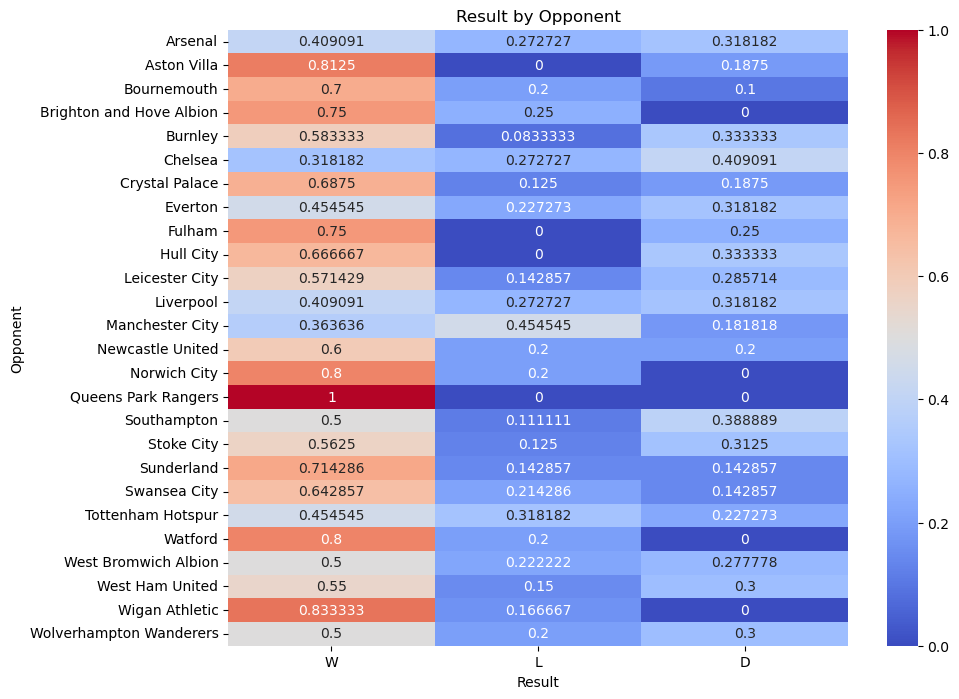

In [17]:
# Tạo bảng dữ liệu cho heatmap
min_usage = 5 
popular_formations = arsenal_df['opponent'].value_counts()[arsenal_df['opponent'].value_counts() > min_usage].index
filtered_df = arsenal_df[arsenal_df['opponent'].isin(popular_formations)]

# Tính toán tỷ lệ phần trăm thay vì số trận
formation_result = filtered_df.groupby(['opponent', 'result']).size().unstack().fillna(0).reindex(columns=["W", "L", "D"])
formation_result = formation_result.div(filtered_df.groupby(['opponent']).size(), axis=0)

# Vẽ biểu đồ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(formation_result, annot=True, cmap='coolwarm', fmt='g')
plt.title('Result by Opponent')
plt.xlabel('Result')
plt.ylabel('Opponent');

Nhận xét: 
- Tỉ lệ thắng, thua, hoà có một sự khác biệt khi đấu với các đội khác nhau
    + Lúc thì %W thắng cao nhất, lúc thì %L cao nhất
    + Do đó sẽ đưa biến opponent vào quá trình training

### 4. Ảnh hưởng của lịch sử đối đầu đến biến result

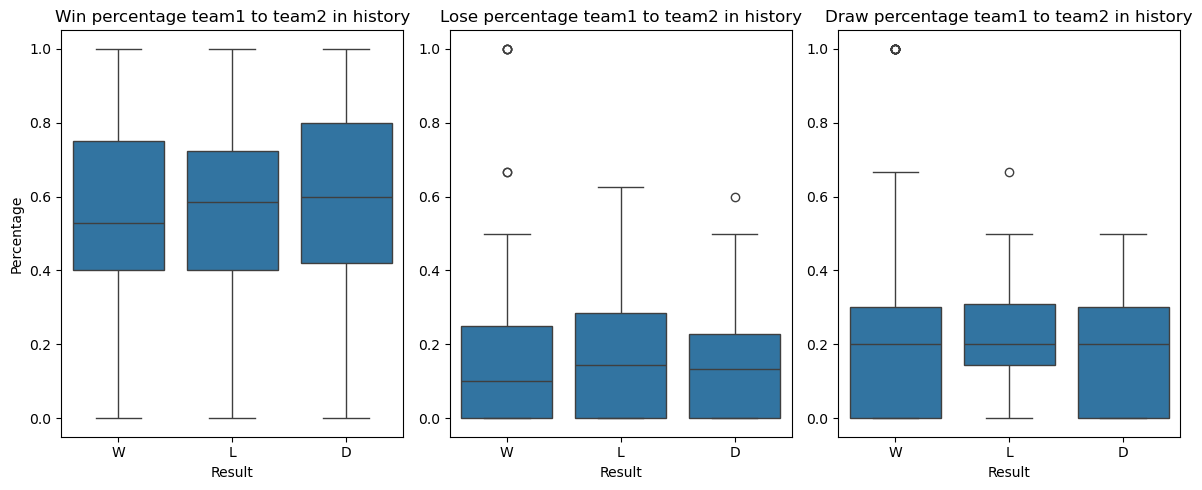

In [18]:
# Vẽ biểu đồ box plot thể hiện ảnh hưởng của tỷ lệ thắng 5 trận trước đó của 2 team đến kết quả trận đấu
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
order = ['W', 'L', 'D']

sns.boxplot(x='result', y='head2head_win_percent', data=arsenal_df, ax=axes[0], order=order)
axes[0].set_title('Win percentage team1 to team2 in history')
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.boxplot(x='result', y='head2head_lost_percent', data=arsenal_df, ax=axes[1], order=order)
axes[1].set_title('Lose percentage team1 to team2 in history')
axes[1].set_xlabel('Result')
axes[1].set_ylabel(None)

sns.boxplot(x='result', y='head2head_draw_percent', data=arsenal_df, ax=axes[2], order=order)
axes[2].set_title('Draw percentage team1 to team2 in history')
axes[2].set_xlabel('Result')
axes[2].set_ylabel(None)

plt.tight_layout()

Nhận xét:
- Khi team1 có `%W` gặp team2 trước đây cao thì tỉ lệ thắng, hoà của team1 khi đấu với team2 thì tỉ lệ thắng trong trận tiếp theo sẽ cao và tỉ lệ thua thấp
- Khi team1 có` %L` gặp team2 trước đây cao thì tỉ lệ thua, hoà của team1 khi đấu với team2 trong trận tiếp theo sẽ cao và tỉ lệ thắng thấp
- Còn khi `%D` cao thì tỉ lệ thắng, hoà của team1 sẽ cao, thua sẽ thấp
Vậy lịch sử gặp nhau thông qua 3 đặc trưng (`history_team1_win_team2`, `history_team1_draw_team2`, `history_team1_lose_team2`) sẽ `được đưa` vào quá trình training vì nó có ảnh hưởng đến kết quả trận đấu

### 5. Xem xét sự ảnh hưởng của biến is_opponent_big6 đến kết quả

In [19]:
result_count = arsenal_df.groupby(['is_opponent_big6', 'result']).size().unstack().reindex(["W", "L", "D"], axis=1)
is_big6_count = arsenal_df.groupby(['is_opponent_big6']).size()

result_count, is_big6_count

(result              W   L   D
 is_opponent_big6             
 0                 195  45  68
 1                  43  35  32,
 is_opponent_big6
 0    308
 1    110
 dtype: int64)

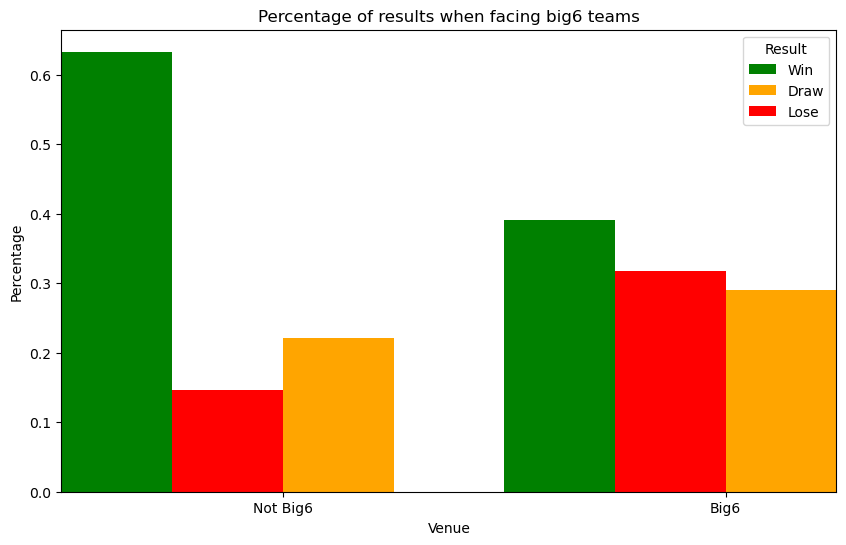

In [20]:
# Thay vì gôm W, L, D vào 1 cột thì ta sẽ tách ra:
result_percentage = result_count.div(is_big6_count, axis=0)
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ biểu đồ cho kết quả Win
result_percentage['W'].plot(kind='bar', ax=ax, color='green', position=2, width=0.25, label='Win')

# Vẽ biểu đồ cho kết quả Draw
result_percentage['D'].plot(kind='bar', ax=ax, color='orange', position=0, width=0.25, label='Draw')

# Vẽ biểu đồ cho kết quả Lose
result_percentage['L'].plot(kind='bar', ax=ax, color='red', position=1, width=0.25, label='Lose')

plt.title("Percentage of results when facing big6 teams")
plt.xlabel("Venue")
plt.ylabel("Percentage")
plt.xticks(ticks=[0, 1], labels=['Not Big6', 'Big6'], rotation=0);
plt.legend(title='Result')

plt.show()

Nhận xét:
- Khi gặp Big6 thì tỉ lệ thua cao hơn rõ rệt, tỉ lệ thắng và hoà thì xấp xỉ nhau
- Khi không gặp Big6 thì tỉ lệ thắng lại cao, và tỉ lệ thua, hoà xấp xỉ nhau
Vậy is_opponent_big6 ảnh hưởng rõ rệt đến kết quả thi đấu của trận hiện tại, do đó sẽ đưa đặc trưng này vào việc dự đoán.

### 6. Xem xét sự ảnh hưởng của biến ELO đến kết quả

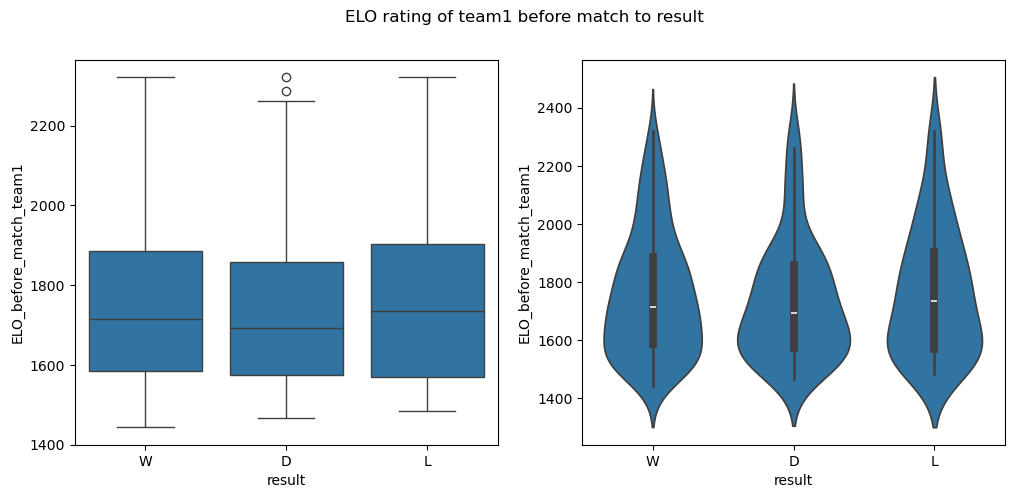

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(x='result', y='ELO_before_match_team1', data=arsenal_df, ax=axes[0])

sns.violinplot(x='result', y='ELO_before_match_team1', data=arsenal_df, ax=axes[1])
plt.suptitle("ELO rating of team1 before match to result");

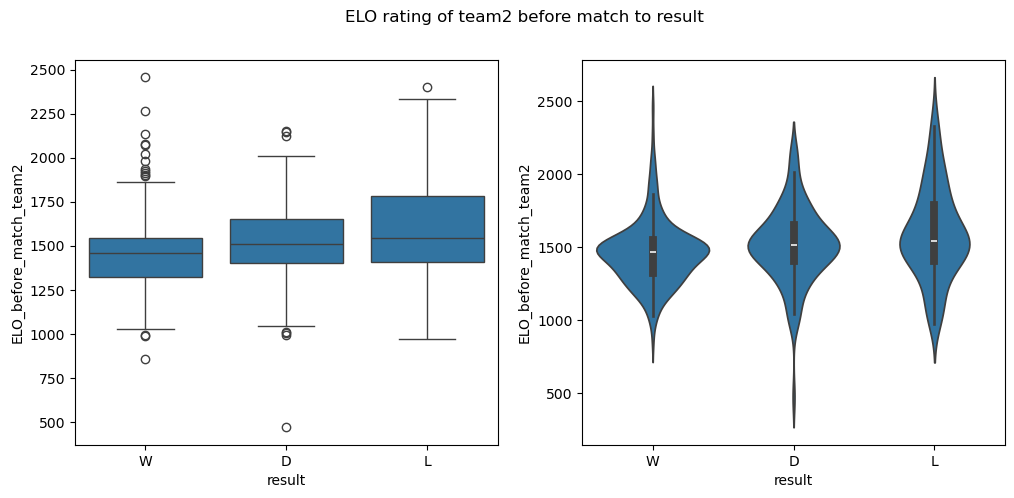

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(x='result', y='ELO_before_match_team2', data=arsenal_df, ax=axes[0])

sns.violinplot(x='result', y='ELO_before_match_team2', data=arsenal_df, ax=axes[1])
plt.suptitle("ELO rating of team2 before match to result");

#### ELO trước trận của team1 không ảnh hưởng nhiều, thử tìm hiệu ELO giữa 2 đội

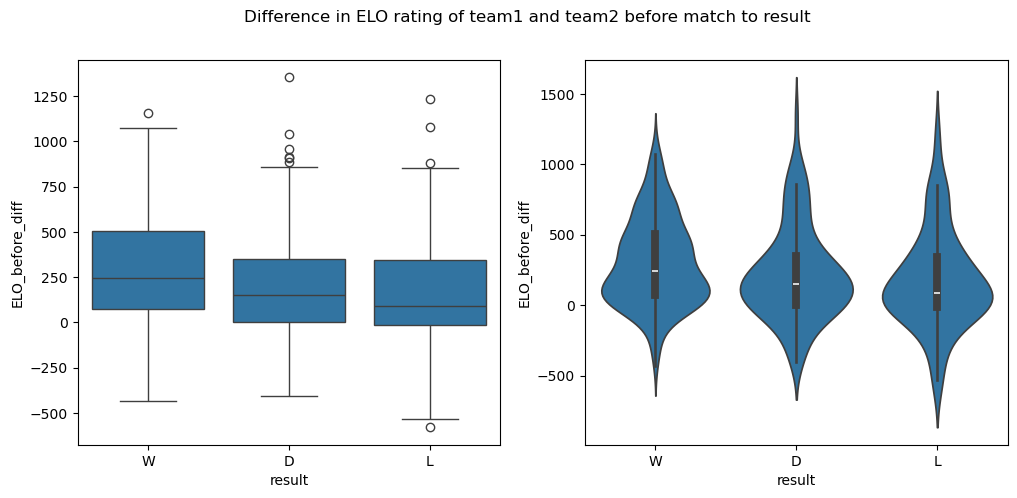

In [23]:
arsenal_df["ELO_before_diff"] = arsenal_df['ELO_before_match_team1'] - arsenal_df['ELO_before_match_team2']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(x='result', y='ELO_before_diff', data=arsenal_df, ax=axes[0])

sns.violinplot(x='result', y='ELO_before_diff', data=arsenal_df, ax=axes[1])
plt.suptitle("Difference in ELO rating of team1 and team2 before match to result");

Nhận xét:
- Dùng `ELO_before_match_team2`, `ELO_before_diff` làm biến dự đoán

### 7. Xem xét biến điểm trung bình trong 5 trận gần nhất của 2 đội đến kết quả

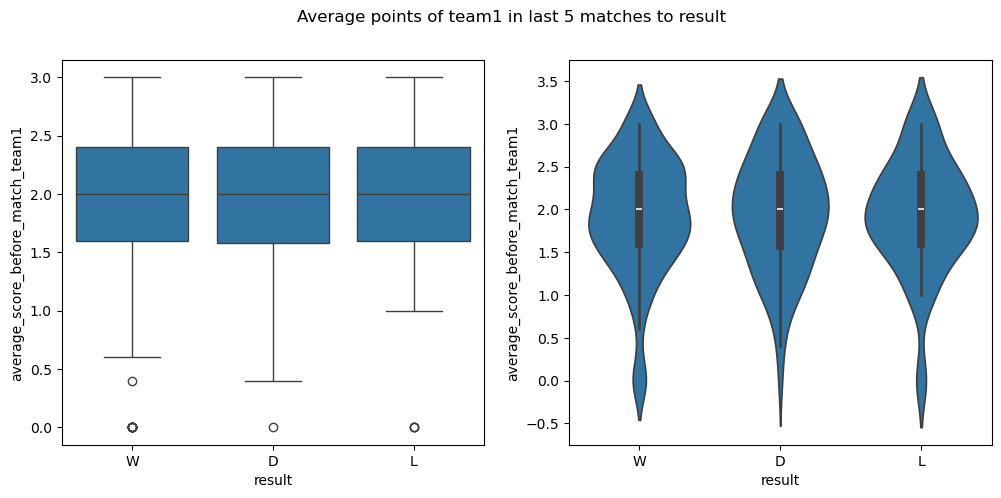

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(x='result', y='average_score_before_match_team1', data=arsenal_df, ax=axes[0])

sns.violinplot(x='result', y='average_score_before_match_team1', data=arsenal_df, ax=axes[1])
plt.suptitle("Average points of team1 in last 5 matches to result");

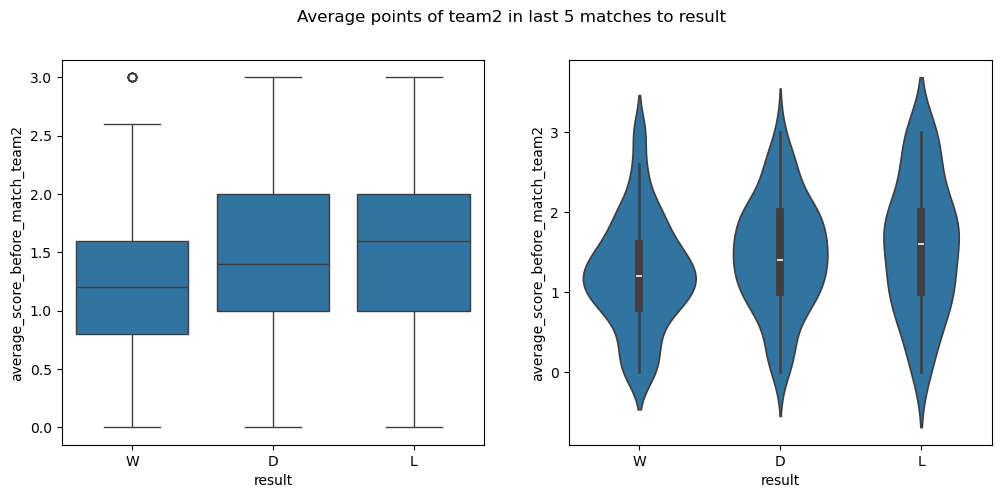

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(x='result', y='average_score_before_match_team2', data=arsenal_df, ax=axes[0])

sns.violinplot(x='result', y='average_score_before_match_team2', data=arsenal_df, ax=axes[1])
plt.suptitle("Average points of team2 in last 5 matches to result");

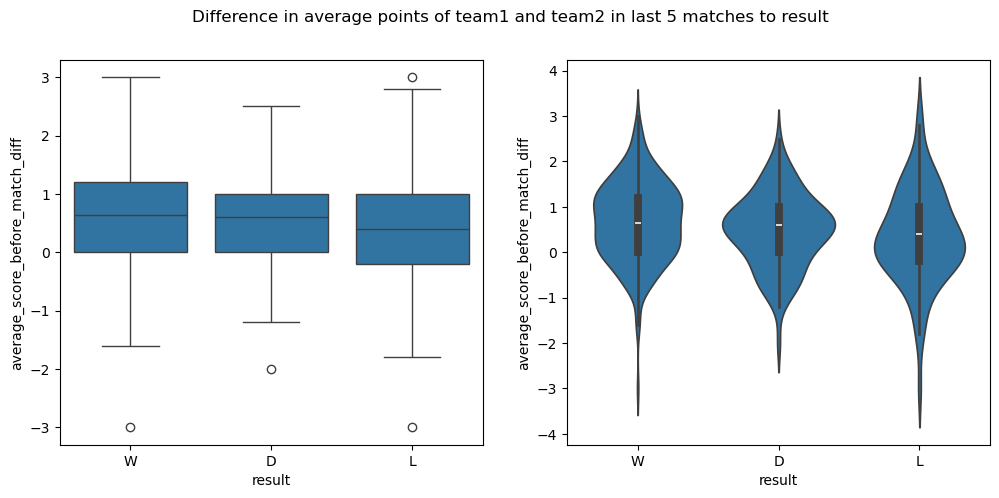

In [26]:
# Hiệu số điểm trung bình của 2 đội trong 5 trận gần nhất
arsenal_df["average_score_before_match_diff"] = arsenal_df['average_score_before_match_team1'] - arsenal_df['average_score_before_match_team2']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(x='result', y='average_score_before_match_diff', data=arsenal_df, ax=axes[0])
sns.violinplot(x='result', y='average_score_before_match_diff', data=arsenal_df, ax=axes[1])
plt.suptitle("Difference in average points of team1 and team2 in last 5 matches to result");

Nhận xét:
- Dùng đặc trưng: `average_score_before_match_team1`, `average_score_before_match_team2`, `average_score_diff` làm biến dự đoán

### Kết luận
Các đặc trưng sẽ dùng cho việc dự đoán:
- venue
- season
- Các đặc trưng về phong độ 2 đội: `win_percent_before_team2`, `lose_percent_before_team2`
- Các đặc trưng về lịch sử đối đầu: `history_team1_win_team2`, `history_team1_draw_team2`, `history_team1_lose_team2`
- is_opponent_big6
- `ELO_before_match_team2`, `ELO_before_diff`

In [27]:
final_df = arsenal_df[
    [
        "result",
        "venue",
        "season",
        "win_percent_diff",
        "draw_percent_before_team2",
        "draw_percent_diff",
        "lose_percent_before_team1",
        "lose_percent_before_team2",
        "head2head_win_percent",
        "head2head_draw_percent",
        "head2head_lost_percent",
        "is_opponent_big6",
        "ELO_before_match_team2",
        "ELO_before_diff",
        "average_score_before_match_team2",
        "average_score_before_match_diff"
    ]
]

In [28]:
final_df.to_csv("../../data_for_training/MU.csv", index=False)